111.0-BDP-revamp-cascade


Text(0.5, 1, 'Feedforward block probability matrix')

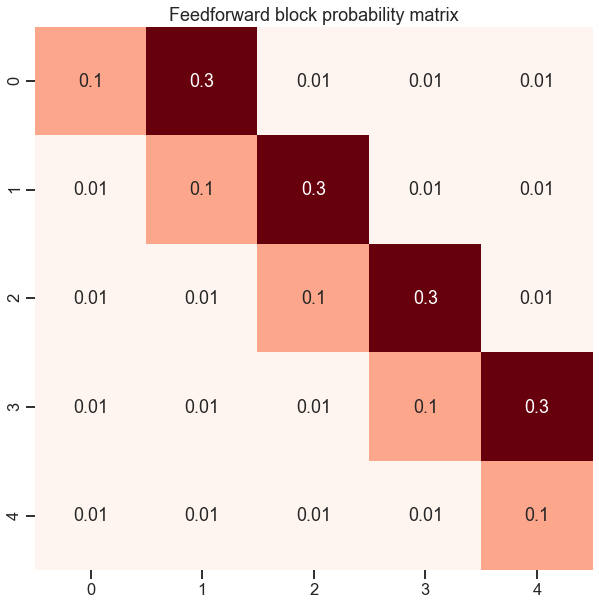

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from graspy.simulations import sbm
from src.io import savefig
from graspy.plot import heatmap


FNAME = os.path.basename(__file__)[:-3]
print(FNAME)

sns.set_context("talk")


def stashfig(name, **kws):
    savefig(name, foldername=FNAME, save_on=True, **kws)


def get_feedforward_B(low_p, diag_p, feedforward_p, n_blocks=5):
    B = np.zeros((n_blocks, n_blocks))
    B += low_p
    B -= np.diag(np.diag(B))
    B -= np.diag(np.diag(B, k=1), k=1)
    B += np.diag(diag_p * np.ones(n_blocks))
    B += np.diag(feedforward_p * np.ones(n_blocks - 1), k=1)
    return B


low_p = 0.01
diag_p = 0.1
feedforward_p = 0.3
n_blocks = 5


block_probs = get_feedforward_B(low_p, diag_p, feedforward_p, n_blocks=n_blocks)
plt.figure(figsize=(10, 10))
sns.heatmap(block_probs, annot=True, cmap="Reds", cbar=False)
plt.title("Feedforward block probability matrix")


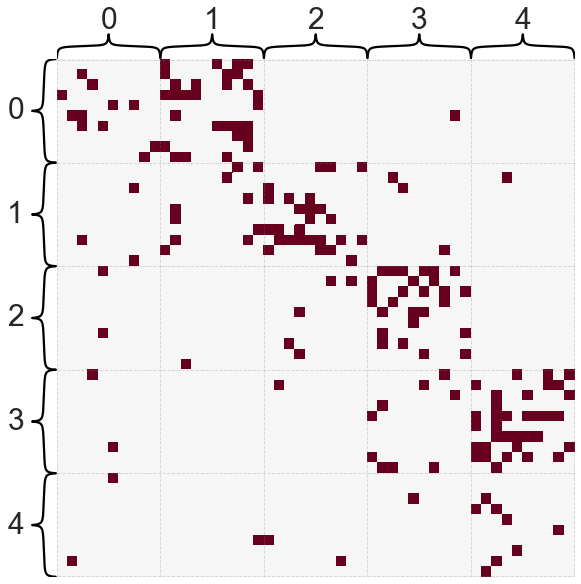

In [2]:
community_sizes = np.empty(2 * n_blocks, dtype=int)
n_feedforward = 10
community_sizes = n_blocks * [n_feedforward]

np.random.seed(88)
A, labels = sbm(
    community_sizes, block_probs, directed=True, loops=False, return_labels=True
)
n_verts = A.shape[0]

heatmap(A, inner_hier_labels=labels, cbar=False)

 ## Demonstrate the simplest random walk

In [3]:
from src.traverse import to_markov_matrix, RandomWalk

transition_probs = to_markov_matrix(A)  # row normalize!
rw = RandomWalk(transition_probs, allow_loops=True, stop_nodes=[], max_hops=10)

np.random.seed(8888)
rw.start(0)
print(rw.traversal_)  # this one stops at max hops
print()

np.random.seed(2222)
rw.start(0)
print(rw.traversal_)  # note that this one lands on a node with no output (41) and stops


[0, 18, 26, 31, 21, 26, 39, 36, 44, 43]

[0, 17, 18, 37, 44, 43, 42, 41]


 ## Look what happens when we introduce `stop_nodes`

In [4]:
rw = RandomWalk(transition_probs, allow_loops=True, stop_nodes=[18])

np.random.seed(8888)
rw.start(0)
print(rw.traversal_)
print()

np.random.seed(2222)
rw.start(0)
print(rw.traversal_)


[0, 18]

[0, 17, 18]


 ## Look what happens when we make `allow_loops=False`

In [5]:
rw = RandomWalk(transition_probs, allow_loops=False)

np.random.seed(8888)
rw.start(0)
print(rw.traversal_)  # this one no longer revisits node 26
print()

np.random.seed(2222)
rw.start(0)
print(rw.traversal_)  # this one was unaffected


[0, 18, 26, 31, 21]

[0, 17, 18, 37, 44, 43, 42, 41]


 # Demonstrate the simplest cascade

In [6]:
from src.traverse import Cascade, to_transmission_matrix

p = 0.2
transition_probs = to_transmission_matrix(A, p)
casc = Cascade(transition_probs)

np.random.seed(88)
casc.start(0)
print(casc.traversal_)
print()

np.random.seed(22)
casc.start(0)
print(casc.traversal_)
# rather than a path, this now is a list of "levels" of the cascade, where each level
# is an array of potentially multiple nodes active at that hop


[array([0]), array([10, 15])]

[array([0]), array([17]), array([18, 21, 22]), array([33, 34, 39]), array([32, 42]), array([34, 38]), array([42])]


 ## Note we can also start at a set of nodes at the same time

In [7]:
np.random.seed(88)
casc.start([0, 1, 2, 3])
print(casc.traversal_)
print()

np.random.seed(22)
casc.start([0, 1, 2, 3])
print(casc.traversal_)


[array([0, 1, 2, 3]), array([ 0, 10, 11, 15, 16]), array([17, 29, 43]), array([18, 21, 29]), array([26]), array([31, 39]), array([31, 32]), array([40, 45, 47])]

[array([0, 1, 2, 3]), array([ 0, 10, 13, 17]), array([18, 24]), array([20, 34]), array([ 4, 42]), array([34])]


 ## We can again introduce `stop_nodes`

In [8]:
casc = Cascade(transition_probs, stop_nodes=[18, 21])

np.random.seed(88)
casc.start(0)
print(casc.traversal_)  # unaffected
print()

np.random.seed(22)
casc.start(0)
print(casc.traversal_)  # fewer nodes active after hop 3, since 18 and 21 stop


[array([0]), array([10, 15])]

[array([0]), array([17]), array([18, 21, 22]), array([33]), array([42])]


 ## We can again disallow loops with `allow_loops=False`

In [9]:
casc = Cascade(transition_probs, allow_loops=False)

np.random.seed(88)
casc.start(0)
print(casc.traversal_)
print()

np.random.seed(22)
casc.start(0)
print(casc.traversal_)  # 42 is no longer visited twice


[array([0]), array([10, 15])]

[array([0]), array([17]), array([18, 21, 22]), array([33, 34, 39]), array([32, 42]), array([38])]


Saved figure to maggot_models/notebooks/outs/111.0-BDP-revamp-cascade/figs/sbm-B.png
Saved figure to maggot_models/notebooks/outs/111.0-BDP-revamp-cascade/figs/sbm.png


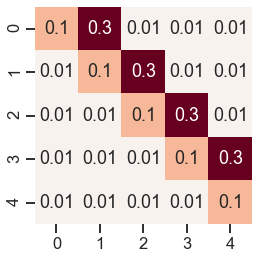

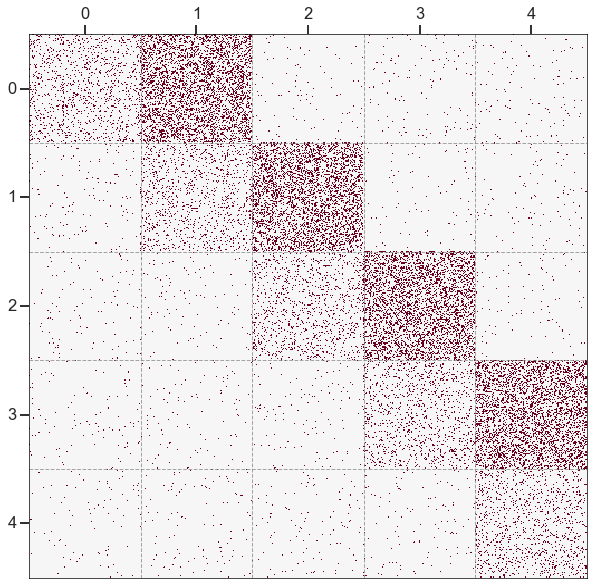

In [10]:
from src.traverse import TraverseDispatcher
from src.visualization import matrixplot

n_feedforward = 100
community_sizes = n_blocks * [n_feedforward]

np.random.seed(8888)
A, labels = sbm(
    community_sizes, block_probs, directed=True, loops=False, return_labels=True
)
n_verts = A.shape[0]

sns.heatmap(block_probs, square=True, cmap="RdBu_r", center=0, annot=True, cbar=False)
stashfig("sbm-B")

matrixplot(A, row_sort_class=labels, col_sort_class=labels, cbar=False)
stashfig("sbm")


Saved figure to maggot_models/notebooks/outs/111.0-BDP-revamp-cascade/figs/hop-hist-cascade-p0.05-simultTrue.png


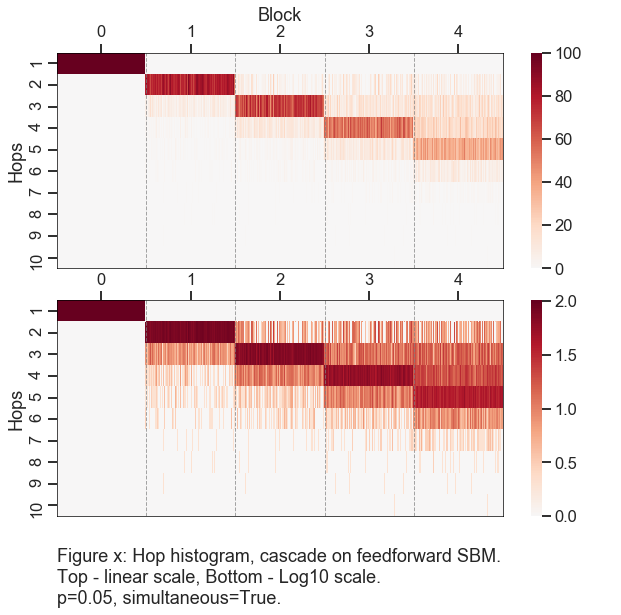

In [11]:
p = 0.05
max_hops = 10
n_init = 100
simultaneous = True
transition_probs = to_transmission_matrix(A, p)
start_nodes = np.arange(n_feedforward)

cdispatch = TraverseDispatcher(
    Cascade,
    transition_probs,
    allow_loops=False,
    n_init=n_init,
    simultaneous=simultaneous,
)
hit_hist = cdispatch.multistart(start_nodes)

fig, axs = plt.subplots(
    3, 1, figsize=(10, 10), gridspec_kw=dict(height_ratios=[0.45, 0.45, 0.1])
)
ax = axs[0]
matrixplot(hit_hist.T, ax=ax, col_sort_class=labels, cbar=True)
ax.set_xlabel("Block")
ax.set_yticks(np.arange(1, max_hops + 1) - 0.5)
ax.set_yticklabels(np.arange(1, max_hops + 1))
ax.set_ylabel("Hops")
ax = axs[1]
matrixplot(np.log10(hit_hist.T + 1), ax=ax, col_sort_class=labels, cbar=True)
ax.set_yticks(np.arange(1, max_hops + 1) - 0.5)
ax.set_yticklabels(np.arange(1, max_hops + 1))
ax.set_ylabel("Hops")
ax = axs[2]
ax.axis("off")
caption = f"Figure x: Hop histogram, cascade on feedforward SBM.\n"
caption += "Top - linear scale, Bottom - Log10 scale.\n"
caption += f"p={p}, simultaneous={simultaneous}."
ax.text(0, 1, caption, va="top")
stashfig(f"hop-hist-cascade-p{p}-simult{simultaneous}")


Saved figure to maggot_models/notebooks/outs/111.0-BDP-revamp-cascade/figs/hop-hist-rw.png


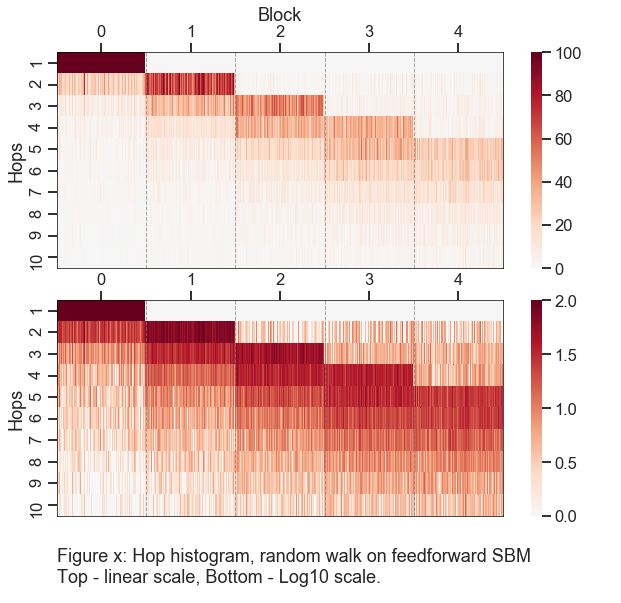

In [12]:
transition_probs = to_markov_matrix(A)
start_nodes = np.arange(n_feedforward)
max_hops = 10
n_init = 100

cdispatch = TraverseDispatcher(
    RandomWalk,
    transition_probs,
    allow_loops=False,
    n_init=n_init,
    max_hops=max_hops,
    stop_nodes=np.arange((n_blocks - 1) * n_feedforward, n_blocks * n_feedforward),
    simultaneous=False,
)

hit_hist = cdispatch.multistart(start_nodes)

fig, axs = plt.subplots(
    3, 1, figsize=(10, 10), gridspec_kw=dict(height_ratios=[0.45, 0.45, 0.1])
)
ax = axs[0]
matrixplot(hit_hist.T, ax=ax, col_sort_class=labels, cbar=True)
ax.set_xlabel("Block")
ax.set_ylabel("Hops")
ax.set_yticks(np.arange(1, max_hops + 1) - 0.5)
ax.set_yticklabels(np.arange(1, max_hops + 1))
ax = axs[1]
matrixplot(np.log10(hit_hist.T + 1), ax=ax, col_sort_class=labels, cbar=True)
ax.set_ylabel("Hops")
ax.set_yticks(np.arange(1, max_hops + 1) - 0.5)
ax.set_yticklabels(np.arange(1, max_hops + 1))
ax = axs[2]
ax.axis("off")
caption = f"Figure x: Hop histogram, random walk on feedforward SBM\n"
caption += "Top - linear scale, Bottom - Log10 scale. "
ax.text(0, 1, caption, va="top")
stashfig(f"hop-hist-rw")
